# AI model for predicting the electricity prices

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from LSTMmodel import *

%load_ext autoreload
%autoreload 2

In [3]:
# moving to GPU if available (Metal)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: mps


## Loading the data

In [4]:
# path to the CSV file
path = '../../data/fulldata.csv'

data = pd.read_csv(path)

display(data.head())
print(data.shape)

,SpotPriceDKK,from,to,temp_pca_1,temp_pca_2,temp_pca_3,wind_speed_pca_1,wind_speed_pca_2,wind_speed_pca_3,wind_speed_pca_4,...,mean_wind_dir_pca_39,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,oil_price,gas_price,constant
0,596.570007,2024-11-29 23:00:00+00:00,2024-11-30 00:00:00+00:00,-33.480249,7.339981,1.718044,3.248249,2.159318,0.612078,3.505092,...,-0.093112,-0.258819,0.965926,-0.433884,-0.900969,-0.5,0.866025,72.940002,47.811001,1
1,770.270020,2024-11-29 22:00:00+00:00,2024-11-29 23:00:00+00:00,-32.131543,8.173021,2.038769,2.387323,3.215623,0.288633,3.701821,...,-0.004524,-0.500000,0.866025,-0.433884,-0.900969,-0.5,0.866025,72.940002,47.811001,1
2,848.200012,2024-11-29 21:00:00+00:00,2024-11-29 22:00:00+00:00,-30.659681,8.780246,1.967827,1.620036,2.482432,0.516816,3.950176,...,-0.081036,-0.707107,0.707107,-0.433884,-0.900969,-0.5,0.866025,72.940002,47.811001,1
3,836.049988,2024-11-29 20:00:00+00:00,2024-11-29 21:00:00+00:00,-29.321284,9.297498,1.494915,1.490229,2.968878,1.071656,3.674438,...,-0.073105,-0.866025,0.500000,-0.433884,-0.900969,-0.5,0.866025,72.940002,47.811001,1
4,894.219971,2024-11-29 19:00:00+00:00,2024-11-29 20:00:00+00:00,-27.818541,9.207599,0.853380,2.309477,2.890789,0.990981,2.872615,...,-0.040381,-0.965926,0.258819,-0.433884,-0.900969,-0.5,0.866025,72.940002,47.811001,1


(62280, 68)


## Data preprocessing

In [5]:
data['from'] = pd.to_datetime(data['from'])

# drop to column
data = data.drop(columns=['to'])

# explicitly including lagged prices as well
lag_hours = [0, 
            -1, -2, -3, -4, -5, -6, -24, #-48, -72, -96, -120, -144, -168
             ]
for lag in lag_hours:
    data[f'price_lag_{lag}'] = data['SpotPriceDKK'].shift(lag)

lag_oil_gas = [-24, -48, -72, # -168
               ]
for lag in lag_oil_gas:
    data[f'oil_price_{lag}'] = data['oil_price'].shift(lag)
    data[f'gas_price_{lag}'] = data['gas_price'].shift(lag)

# offset price by 1 day
data['SpotPriceDKK'] = data['SpotPriceDKK'].shift(24)
data['from'] = data['from'].shift(24)

time_features = ['day', 'month']

for i in time_features:
    data[f'{i}_sin'] = data[f'{i}_sin'].shift(24)
    data[f'{i}_cos'] = data[f'{i}_cos'].shift(24)

# drop hour variable
data = data.drop(columns=['hour_sin', 'hour_cos'])

# drop the first 24 rows
data = data.dropna()

# weekdend feature
data['weekend'] = data['from'].dt.dayofweek > 4

# sort data to be ascending
data = data.sort_values('from')

data = data.reset_index(drop=True)

display(data.head())
print(data.shape)

,SpotPriceDKK,from,temp_pca_1,temp_pca_2,temp_pca_3,wind_speed_pca_1,wind_speed_pca_2,wind_speed_pca_3,wind_speed_pca_4,wind_speed_pca_5,...,price_lag_-5,price_lag_-6,price_lag_-24,oil_price_-24,gas_price_-24,oil_price_-48,gas_price_-48,oil_price_-72,gas_price_-72,weekend
0,96.019997,2017-10-27 00:00:00+00:00,11.237675,0.831761,0.323180,6.760909,2.790222,0.398300,3.612175,4.192237,...,219.059998,222.639999,95.199997,58.439999,18.110001,58.330002,17.959999,57.369999,18.09,False
1,95.349998,2017-10-27 01:00:00+00:00,11.377424,0.873795,0.021477,5.367659,1.404028,0.596286,4.109275,3.550561,...,210.059998,219.059998,104.129997,58.439999,18.110001,58.330002,17.959999,57.369999,18.09,False
2,141.729996,2017-10-27 02:00:00+00:00,11.360804,0.662414,-0.153373,4.258495,1.098352,-0.898239,4.812269,2.074639,...,201.720001,210.059998,126.760002,58.439999,18.110001,58.330002,17.959999,57.369999,18.09,False
3,178.720001,2017-10-27 03:00:00+00:00,11.961742,0.604866,-0.202105,3.781656,0.551939,-0.444115,4.825875,1.811022,...,194.720001,201.720001,196.139999,58.439999,18.110001,58.330002,17.959999,57.369999,18.09,False
4,238.199997,2017-10-27 04:00:00+00:00,12.162359,0.136666,-0.113291,3.029801,1.184454,-0.552593,5.198467,2.016204,...,186.460007,194.720001,258.070007,58.439999,18.110001,58.330002,17.959999,57.369999,18.09,False


(62184, 80)


In [6]:
# extract column names
cols = data.columns.tolist()

# select features and target variable
all_features = cols[2:]
target = cols[:1]

print(f'Count of features before interaction terms: {len(all_features)}')
print(f'Target variable: {target}')

Count of features before interaction terms: 78
Target variable: ['SpotPriceDKK']


In [7]:
# split into 24 datasets, one for each hour of the day
datasets = []
for i in range(24):
    datasets.append(data[data['from'].dt.hour == i])

# split into train, val and test, for dates ['from'] < '2023-08-01' (data['from'] >= '2023-08-01') & (data['from'] < '2024-08-01') and data['from'] >= '2024-08-01' respectively
train = []
val = []
test = []
for i in range(24):
    train.append(datasets[i][(datasets[i]['from'] < '2023-08-01')])
    val.append(datasets[i][(datasets[i]['from'] >= '2023-08-01') & (datasets[i]['from'] < '2024-08-01')])
    test.append(datasets[i][(datasets[i]['from'] >= '2024-07-31')])  # initialized 24 hours before to get the first 24 hours

X_train = []
X_val = []
X_test = []
y_train = []
y_val = []
y_test = []
for i in range(24):
    X_train.append(train[i][all_features].values)
    X_val.append(val[i][all_features].values)
    X_test.append(test[i][all_features].values)

    scalar = StandardScaler()
    X_train[i] = scalar.fit_transform(X_train[i])
    X_val[i] = scalar.transform(X_val[i])
    X_test[i] = scalar.transform(X_test[i])

    y_train.append(train[i][target].values)
    y_val.append(val[i][target].values)
    y_test.append(test[i][target].values)

    

## Model building

In [8]:
# set seed for reproducibility
torch.manual_seed(2024)
np.random.seed(2024)

# hyperparameters
seq_length = 7  # Use past week to form a sequence
batch_size = 256
input_dim = X_train[1].shape[1]
output_dim = 1
learning_rate = 0.0025

# arrays for tuning
lambda_l1_array = [1e-1]
lambda_l2_array = [1e-4]
hidden_dim_array = [512]
layer_dim_array = [2]

# loss evaluation function
criterion = nn.MSELoss()

In [9]:
train_loader = []
val_loader = []
test_loader = []
for i in range(24):
    train_data = dataset(X_train[i], y_train[i], seq_length)
    val_data = dataset(X_val[i], y_val[i], seq_length)
    test_data = dataset(X_test[i], y_test[i], seq_length)
    torch.manual_seed(2024)
    np.random.seed(2024)
    train_loader.append(DataLoader(train_data, batch_size=batch_size, shuffle=True))
    val_loader.append(DataLoader(val_data, batch_size=batch_size, shuffle=False))
    test_loader.append(DataLoader(test_data, batch_size=batch_size, shuffle=False))

## Hyper parameter tuning

In [9]:
# training the model
num_epochs = 250
patience = 10  # for early stopping
best_loss_global = np.inf

for i in range(24):
    print(f"Training model for hour {i}")
    for hidden_dim in hidden_dim_array:
        for layer_dim in layer_dim_array:
            for lambda_l1 in lambda_l1_array:
                for lambda_l2 in lambda_l2_array:
                    torch.manual_seed(2024)
                    np.random.seed(2024)
                    model = LSTMmodel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
                    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                    # set seed for reproducibility
                    best_loss = np.inf
                    counter = 0

                    # initialize lists to store loss values
                    training_losses = []
                    validation_losses = []

                    for epoch in range(num_epochs):
                        model.train()
                        train_loss = 0
                        for X_batch, y_batch in train_loader[i]:
                            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                            optimizer.zero_grad()

                            # forward pass
                            outputs = model(X_batch)

                            mse_loss = criterion(outputs.squeeze(), y_batch.squeeze())

                            # L1 regularization
                            l1_loss = l1_regularization(model, lambda_l1)
                            l2_loss = l2_regularization(model, lambda_l2)

                            # calc total loss
                            loss = mse_loss + l1_loss + l2_loss

                            # backward pass and optimization
                            loss.backward()
                            optimizer.step()

                            train_loss += loss.item()


                        # average training loss
                        avg_train_loss = train_loss / len(train_loader[i])
                        training_losses.append(avg_train_loss)

                        # validation
                        model.eval()
                        val_losses = []
                        with torch.no_grad():
                            for X_batch, y_batch in val_loader[i]:
                                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                                outputs = model(X_batch)
                                mse_loss = criterion(outputs.squeeze(), y_batch.squeeze())
                                loss = mse_loss
                                val_losses.append(loss.item())

                        avg_val_loss = np.mean(val_losses)
                        validation_losses.append(avg_val_loss)
                        if (epoch + 1) % 50 == 0:
                            print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
                        # torch.save(model.state_dict(), 'output/nn-paths/last_model.pth')
                        
                        # early stopping
                        if avg_val_loss < best_loss:
                            best_loss = avg_val_loss
                            counter = 0
                            # save the best model
                            torch.save(model.state_dict(), f'/Users/johan/Documents/04 Uni/09 Asset Pricing Data/hour paths/best_model_{layer_dim}_{hidden_dim}_{int(np.abs(np.log10(lambda_l1)))}_{int(np.abs(np.log10(lambda_l2)))}_hour{i}.pth')
                        else:
                            counter += 1
                            if counter >= patience:
                                print(f"Early stopping after {epoch} epochs. Best validation loss: {best_loss:.4f}")
                                break
                        
                        if epoch == (num_epochs - 1):
                            print(f"Training stopped after {epoch} epochs. Best validation loss: {best_loss:.4f}")


Training model for hour 0
Epoch [50/250], Training Loss: 481330.7361, Validation Loss: 144881.1797
Epoch [100/250], Training Loss: 461937.8368, Validation Loss: 85837.7109
Epoch [150/250], Training Loss: 383512.0868, Validation Loss: 57548.8711
Epoch [200/250], Training Loss: 296887.9913, Validation Loss: 49479.3535
Early stopping after 215 epochs. Best validation loss: 48349.8535
Epoch [50/250], Training Loss: 481318.8611, Validation Loss: 144882.2891
Epoch [100/250], Training Loss: 461628.3542, Validation Loss: 85735.0234
Epoch [150/250], Training Loss: 383184.2014, Validation Loss: 56586.9258
Epoch [200/250], Training Loss: 296786.3958, Validation Loss: 47118.2520
Early stopping after 209 epochs. Best validation loss: 47118.2520
Epoch [50/250], Training Loss: 481319.4236, Validation Loss: 144882.0625
Epoch [100/250], Training Loss: 461920.8056, Validation Loss: 85751.6641
Epoch [150/250], Training Loss: 383698.8056, Validation Loss: 57707.5430
Epoch [200/250], Training Loss: 296293.

## Model evaluation

### Evaluating all models in the grid search

In [10]:
# # update the array to load all models
# lambda_l1_array = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
# lambda_l2_array = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
# hidden_dim_array = [128, 256, 512]
# layer_dim_array = [2, 3]


In [10]:
best_val_loss = np.inf

for hidden_dim in hidden_dim_array:
    for layer_dim in layer_dim_array:
        for lambda_l1 in lambda_l1_array:
            for lambda_l2 in lambda_l2_array:

                all_val_losses = []
                all_predictions = []  # Store predictions for ALL hours
                all_actuals = []      # Store actual targets for ALL hours

                for i in range(24):
                    model_path = f'/Users/johan/Documents/04 Uni/09 Asset Pricing Data/hour paths/best_model_{layer_dim}_{hidden_dim}_{int(np.abs(np.log10(lambda_l1)))}_{int(np.abs(np.log10(lambda_l2)))}_hour{i}.pth'

                    # Load the LSTM model
                    model = LSTMmodel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
                    model.load_state_dict(torch.load(model_path))
                    model.eval()

                    # --- Validation Loss for hour i ---
                    val_losses_hour = []
                    with torch.no_grad():
                        for X_batch, y_batch in val_loader[i]:
                            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                            outputs = model(X_batch)
                            mse_loss = criterion(outputs.squeeze(), y_batch.squeeze())
                            val_losses_hour.append(mse_loss.item())

                    if len(val_losses_hour) == 0:
                        continue
                    hour_val_loss = np.mean(val_losses_hour)
                    all_val_losses.append(hour_val_loss)

                    # --- Test predictions for hour i ---
                    with torch.no_grad():
                        for X_batch, y_batch in test_loader[i]:
                            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                            outputs = model(X_batch)
                            # extend them into the global lists
                            all_predictions.extend(outputs.squeeze().tolist())
                            all_actuals.extend(y_batch.squeeze().tolist())

                # 1. Compute aggregated validation loss (averaged across hours)
                avg_val_loss = np.mean(all_val_losses)

                # 2. Compute single RMSE / MAE on the combined *entire day* test data
                overall_rmse = root_mean_squared_error(all_actuals, all_predictions)
                overall_mae = mean_absolute_error(all_actuals, all_predictions)

                # Compare to best so far
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    best_hidden_dim = hidden_dim
                    best_lambda_l1 = lambda_l1
                    best_lambda_l2 = lambda_l2
                    best_layer_dim = layer_dim
                    best_rmse = overall_rmse
                    best_mae = overall_mae

                # Print aggregated results for this hyperparam setting
                print(f'Hidden dim: {hidden_dim}, Layer dim: {layer_dim}, '
                      f'L1: {lambda_l1}, L2: {lambda_l2}, '
                      f'Avg Validation Loss: {avg_val_loss:.4f}')
                print(f'RMSE (overall): {overall_rmse:.4f}, MAE (overall): {overall_mae:.4f}')
                print('---')

# After all hyperparam combos:
print("Best hyperparameters found:")
print(f'Hidden dim = {best_hidden_dim}, Layer dim = {best_layer_dim}, '
      f'L1 = {best_lambda_l1}, L2 = {best_lambda_l2}')
print(f'Validation Loss = {best_val_loss:.4f}, RMSE = {best_rmse:.4f}, MAE = {best_mae:.4f}')

# save the best model as best_model.pth
model = LSTMmodel(input_dim, best_hidden_dim, best_layer_dim, output_dim).to(device)
for i in range(24):
    model.load_state_dict(torch.load(f'/Users/johan/Documents/04 Uni/09 Asset Pricing Data/hour paths/best_model_{layer_dim}_{hidden_dim}_{int(np.abs(np.log10(lambda_l1)))}_{int(np.abs(np.log10(lambda_l2)))}_hour{i}.pth'))
    torch.save(model.state_dict(), f'/Users/johan/Documents/04 Uni/09 Asset Pricing Data/hour paths/best_model_hour{i}.pth')
    print(f'Best model saved as /Users/johan/Documents/04 Uni/09 Asset Pricing Data/hour paths/best_model_hour{i}.pth')

Hidden dim: 512, Layer dim: 2, L1: 0.1, L2: 0.0001, Avg Validation Loss: 72321.7944
RMSE (overall): 358.9551, MAE (overall): 283.6950
---
Best hyperparameters found:
Hidden dim = 512, Layer dim = 2, L1 = 0.1, L2 = 0.0001
Validation Loss = 72321.7944, RMSE = 358.9551, MAE = 283.6950


FileNotFoundError: [Errno 2] No such file or directory: 'output/nn-paths/best_model_2_512_1_4_hour0.pth'

In [12]:
hour_predictions = []  # Store predictions for ALL hours
hour_actuals = []      # Store actual targets for ALL hours

for i in range(24):
    model_path = f'output/nn-paths/best_model_hour[{i}].pth'
    # Load the LSTM model
    model = LSTMmodel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    preds_for_hour_i = []
    acts_for_hour_i = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader[i]:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds_for_hour_i.extend(outputs.squeeze().tolist())
            acts_for_hour_i.extend(y_batch.squeeze().tolist())

    # Store the lists in hourly_predictions / hourly_actuals
    hour_predictions.append(preds_for_hour_i)
    hour_actuals.append(acts_for_hour_i)

hour_predictions = [np.array(p) for p in hour_predictions] 
hour_actuals     = [np.array(a) for a in hour_actuals] 

num_samples_per_hour = len(hour_predictions[0])
assert all(len(hour_predictions[h]) == num_samples_per_hour for h in range(24))

# Stack them to shape (24, num_samples_per_hour)
preds_2d = np.vstack(hour_predictions)  # shape: (24, N)
acts_2d  = np.vstack(hour_actuals) 

preds_ordered = preds_2d.T.reshape(-1)
acts_ordered  = acts_2d.T.reshape(-1)



FileNotFoundError: [Errno 2] No such file or directory: 'output/nn-paths/best_model_hour[0].pth'

In [30]:
root_mean_squared_error(acts_ordered, preds_ordered), mean_absolute_error(acts_ordered, preds_ordered)

(371.53169124862654, 294.91109526943467)

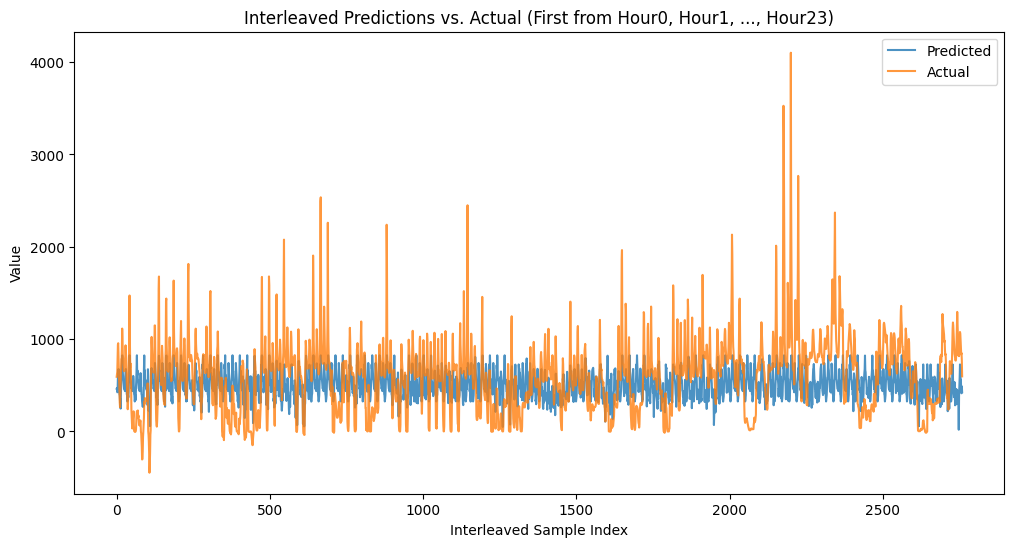

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(preds_ordered, label='Predicted', alpha=0.8)
plt.plot(acts_ordered,  label='Actual', alpha=0.8)
plt.title("Interleaved Predictions vs. Actual (First from Hour0, Hour1, ..., Hour23)")
plt.xlabel("Interleaved Sample Index")
plt.ylabel("Value")
plt.legend()
plt.show()